# Bivariate linear regression

In this tutorial, we introduce the bivariate linear regression based PSM in `p2k`.

In [1]:
%load_ext autoreload
%autoreload 2

import p2k
import pandas as pd
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

## Data preparation

### Proxy

In [2]:
df = pd.read_pickle('./data/pages2k_dataset.pkl')
pdb = p2k.ProxyDatabase().from_df(df)

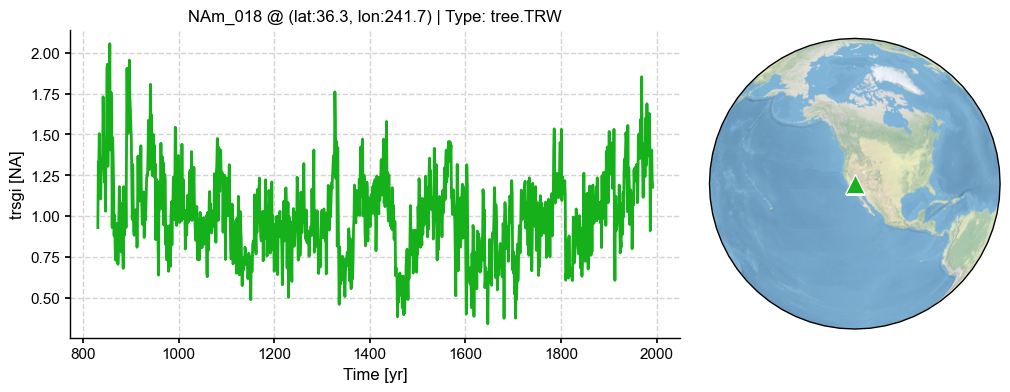

In [3]:
pobj = pdb.records['NAm_018']
fig, ax = pobj.plot()

### Model

In [4]:
dirpath = '/Volumes/ExtraDrive/Data/GCM_sims/icesm_last_millennium_historical'

model_tas = p2k.ClimateField().load_nc(os.path.join(dirpath, 'tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc'))
model_pr = p2k.ClimateField().load_nc(os.path.join(dirpath, 'pr_sfc_Amon_iCESM_past1000historical_085001-200512.nc'))

### Instrumental observations

In [5]:
dirpath = '/Volumes/ExtraDrive/Data/Analyses/CRUTS'

obs_tas_ds = p2k.ClimateDataset().load_nc(os.path.join(dirpath, 'cru_ts4.05.1901.2020.tmp.dat.nc'), vn='tmp')
obs_pr_ds = p2k.ClimateDataset().load_nc(os.path.join(dirpath, 'cru_ts4.05.1901.2020.pre.dat.nc'), vn='pre')

In [6]:
obs_pr = obs_pr_ds.fields['pre'].rename('pr')
obs_tas = obs_tas_ds.fields['tmp'].rename('tas')

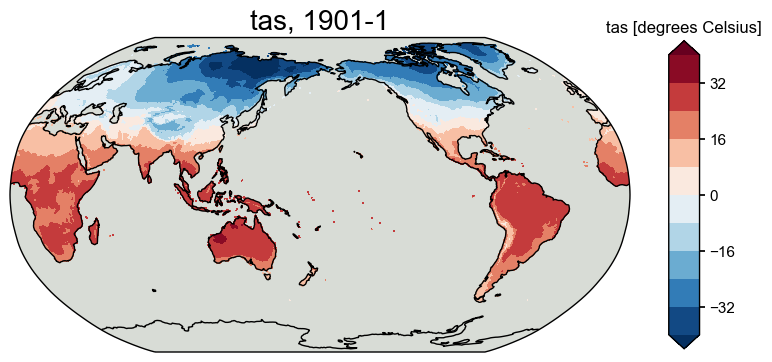

In [7]:
fig, ax = obs_tas.plot(levels=np.linspace(-40, 40, 11))

In [8]:
%%time
obs_tas_new = obs_tas.wrap_lon()

CPU times: user 7.36 s, sys: 1.48 s, total: 8.84 s
Wall time: 8.9 s


In [9]:
obs_tas_new.da.coords

Coordinates:
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2020-12-16

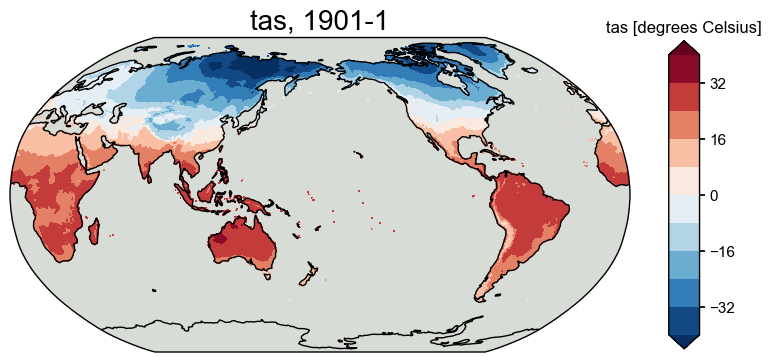

In [10]:
fig, ax = obs_tas_new.plot(levels=np.linspace(-40, 40, 11))

In [11]:
obs_pr.da.coords

Coordinates:
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2020-12-16

In [12]:
obs_pr_new = obs_pr.wrap_lon()

In [13]:
obs_pr_new.da.coords

Coordinates:
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2020-12-16

## Get climate data for a specific `ProxyRecord`

In [14]:
%%time

pobj.del_clim()
pobj.get_clim(model_tas, tag='model')
pobj.get_clim(model_pr, tag='model')
pobj.get_clim(obs_tas_new, tag='obs')
pobj.get_clim(obs_pr_new, tag='obs')

ProxyRecord.clim deleted for NAm_018.
ProxyRecord.clim["model_tas"] created.
ProxyRecord.clim["model_pr"] created.
ProxyRecord.clim["obs_tas"] created.
ProxyRecord.clim["obs_pr"] created.
CPU times: user 107 ms, sys: 4.67 ms, total: 112 ms
Wall time: 112 ms


In [15]:
pobj.clim['obs_tas'].da

<xarray.DataArray 'tas' (time: 1440)>
array([ 0.4,  0.1,  0.5, ..., 10.3,  2.9,  0.9], dtype=float32)
Coordinates:
    lon      float32 241.8
    lat      float32 36.25
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2020-12-16
Attributes:
    long_name:                   near-surface temperature
    units:                       degrees Celsius
    correlation_decay_distance:  1200.0

## Create a PSM object

In [16]:
lr_mdl = p2k.psm.Bilinear(pobj)

In [17]:
%%time
sn_list = [
    [1,2,3,4,5,6,7,8,9,10,11,12],
    [6,7,8],
    [3,4,5,6,7,8],
    [6,7,8,9,10,11],
    [-12,1,2],
    [-9,-10,-11,-12,1,2],
    [-12,1,2,3,4,5]
]
lr_mdl.calibrate(season_list1=sn_list, season_list2=sn_list)

CPU times: user 4.38 s, sys: 104 ms, total: 4.49 s
Wall time: 4.52 s


In [18]:
lr_mdl.calib_details

{'df':         proxy        tas         pr
 time                               
 1901.0  1.518  13.966667  52.891666
 1902.0  1.321  13.366668  48.566669
 1903.0  1.271  13.500000  30.941668
 1904.0  1.257  13.900001  67.641663
 1905.0  1.328  13.166667  53.424999
 ...       ...        ...        ...
 1988.0  1.212  14.700000  54.166668
 1989.0  1.293  14.066667  20.575001
 1990.0  1.405  14.366666  33.791668
 1991.0  1.221  13.666667  48.941666
 1992.0  1.178  13.966667  74.066673
 
 [92 rows x 3 columns],
 'nobs': 92.0,
 'fitR2adj': 0.12693510211897807,
 'PSMresid': time
 1901.0    0.268048
 1902.0    0.117865
 1903.0    0.137505
 1904.0   -0.053343
 1905.0    0.113339
             ...   
 1988.0   -0.077899
 1989.0    0.177525
 1990.0    0.218510
 1991.0    0.002154
 1992.0   -0.163145
 Length: 92, dtype: float64,
 'PSMmse': 0.0437379428850475,
 'SNR': 0.4136778110878698,
 'seasonality': ([6, 7, 8], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])}

In [19]:
%%time
pp = lr_mdl.forward()

CPU times: user 1.18 s, sys: 82.2 ms, total: 1.26 s
Wall time: 1.26 s


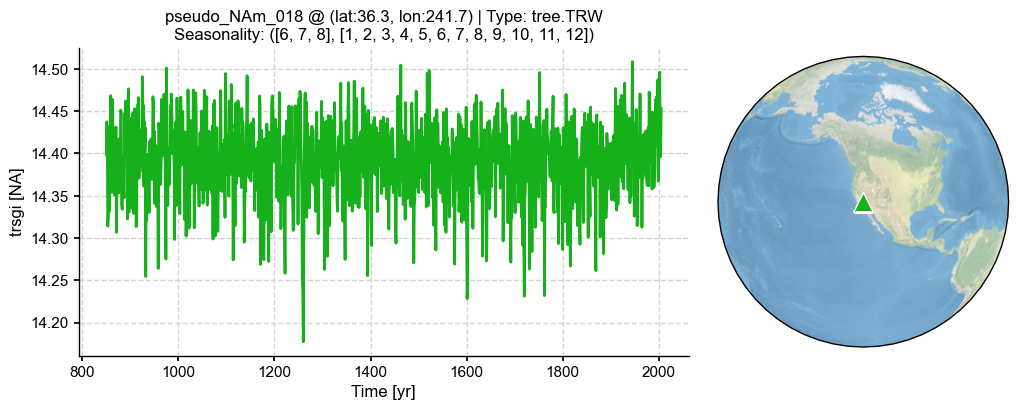

In [20]:
fig, ax = pp.plot()